Unsupervised Learning - Clustering algorithms

# In Depth: Kernel Density Estimation

In the previous section we covered Gaussian mixture models (GMM), which are a kind of hybrid between a clustering estimator and a density estimator. Recall that a density estimator is an algorithm that takes a D-dimensional dataset and produces an estimate of the D-dimensional probability distribution which that data is drawn from. The GMM algorithm accomplishes this by representing the density as a weighted sum of Gaussian distributions. **Kernel density estimation** (KDE) is in some sense an algorithm that takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component **per point**, resulting in an essentially nonparametric estimator of density. In this section, we will explore the motivation and uses of KDE. We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms

As already discussed, a density estimator is an algorithm that seeks to model the probability distribution that generated a dataset. For one-dimensional data, you are probably already familiar with one simple density estimator: the histogram. A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

For example, let's create some data that is drawn from two normal distributions

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

We have previously seen that the standard count-based histogram can be created with the `plt.hist()` function. By specifying the `normed` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflect probability density:

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


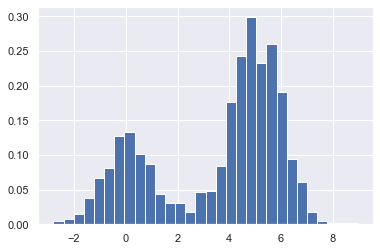

In [3]:
hist = plt.hist(x,bins=30,normed=True)

Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving heights essentially the same as in a histogram built from counts. This normlization is chosen so that the total area under the hostogram is equal to 1, as we can conform by looking at the output of the histogram function:

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features. Fore example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data!

Consider this example:

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


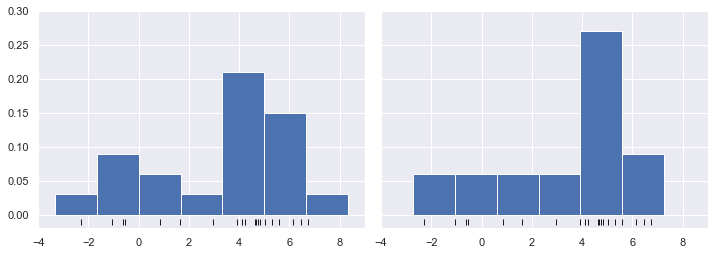

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution. On the right, we see a unimodal distribution with a long trail. Without seeing the preceding code, you would probably not guess that these two histograms were built from the same data. With that in mind, how can you trust the inuition that histograms confer? And how might we improve on this?

Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset. Let's view this directly:

(-0.2, 8)

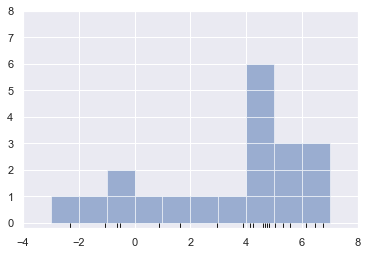

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The problem with our two binning stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points. This misalignment between points and their blocks is a potential cause of the poor histogram results seen here. But what if, instead of stacking the blocks aligned with the **bins**, we were to stack the blocks aligned with the **points they represent**? If we do this, the blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result. Let's try this:

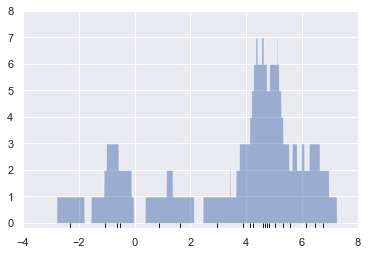

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

The result looks a bit messy, but is a much more robust reflection of the actual data characteristics than is the standard histogram. Still, the rough edges are not aestetically pleasing, nor are they reflective of any true properties of the data. In order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian. Let's use a standard normal curve at each point instead of a block:

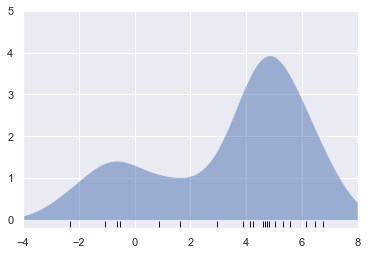

In [9]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution controbuted at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one that has much less variance (i.e., changes much less in response to differences in sampling).

These last two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the second uses a Gaussian kernel. We'll now look at kernel density estimation in more detail.

## Kernel Density Estimation in Practice

The free parameters of kernel density estimation are the **kernel**, which specifies the shape of the distribution placed at each point, and the **kernel bandwidth**, which controlls the size of the kernel at each point. In practice, there are many kernels you might use for a kernel density estimation: in poarticular, the Scikit-Learn KDE implementation supports one of six kernels, which you can read about in the Scikit-Learn's Density Esimation doumentation.

While there are several versions of kernel density estimation implmented in Python (notably in the SciPy and StatsModels packages), I prefer to use Scikit-Learn's versionbecause of its efficiency and flexibility. It is implmented in the `sklearn.neighbors.KernelDensity` estimator, which handles KDE in multiple dimensions with one of six kernels and one of a couple dozen distance metrics. Because KDE can be fairly computationally intensive, the Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the `atol` (absolute tolerance) and `rtol` (relative tolerance) parameters. We can determine the kernel bandwidth, which is a free parameter, using Scikit-Learn's standard cross-validation tools, as we will soon see.

Let's first see a simple example of replicating the preceding plot using Scikit-Learn `KernelDensity` estimator:

(-0.02, 0.22)

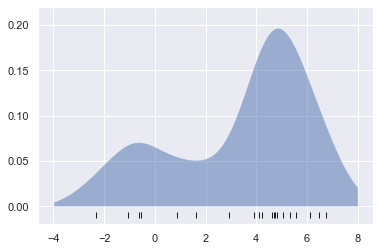

In [10]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

The result here is normalized such that the area under the curve is equal to 1.

### Selecting the bandwidth via cross-validation 

The choice of bandwidth within KDE is extremely important to finding a suitable density estimate, and is the knob that controls the bias-variance trade-off in the estimate of density: too narrow a bandwidth leads to a high-variance estimate (i.e., over-fitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estiamte (i.e., underfitting) where the structure in the data is washed out by the wide kernel.

There is a logn history in statistics of methods to quickly estimate the best bandwidth based on rather stringent assumptions about the data: if you look upt the KDE implementations in the SciPy and StatsModels packages, for example, you will see implementations based on some of these rules.

In machine learning context, we've seen that such hyperparameters tuning often is done emperical;ly via a cross-validation approach. With this in mind, the `KernelDensity` estimator in Scikit-Learn is designed such that it can be used directly within Scikit-Leanr's standard grid search tools. Here we are looking at such a small dataset, we will leave-one-out cross-validation, which minimizes the reduction in traning set size for each cross-validation trial:

In [11]:
# from sklearn.grid_search import GridSearchCV# 
# from sklearn.cross_validation import LeaveOneOut

from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut()) # len(x)
grid.fit(x[:, None]);

Now we can find  the choice of bandwidth that maximizes the score (which in this case defaults to the log-likelihood):

In [12]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

The optimal bandwidth happens to be very close to what we used in the example plot earlier, where the bandwidth was 1.0 (i.e., the default width of `scipy.stats.norm`).

## Example: KDE on a Sphere

Perhaps the most common use of KDE is in graphocally representing distributions of points. For example, in the Seaborn visualization library, KDE  is built in and automatically used to help visualize points in one and two dimensions.

Here we will look at a slightly more sophisticated use of KDE for visualization of distribututions. We will make use of some geographic data that can be loaded with Scikit-Learn: the geographic distributions of recorded observations of two South American mammals, **Bradypus variegatus** (the brown-throated sloth) and **Microryzomys minutus** (the forest small rice rat).

With Scikit-Learn, we can fetch this data as follows:

The free parameters of kernel density estimation are the **kernel**, which specifies the shape of the distribution placed at each point, and the **kernel bandwidth**, which controlls the size of the kernel at each point. In practice, there are many kernels you might use for a kernel density estimation: in poarticular, the Scikit-Learn KDE implementation supports one of six kernels, which you can read about in the Scikit-Learn's Density Esimation doumentation.

In [13]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

With this data loaded, we can use ther Basemap toollkit to plot ther observed locations of these two species on the map of South America

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


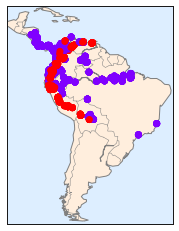

In [16]:
import os # included
os.environ['PROJ_LIB'] = 'C:/Anaconda3/Lib/site-packages/mpl_toolkits/basemap' # included
# I also included the epsg file can also be found on GitHub in the basemap repository! https://github.com/matplotlib/basemap/blob/master/lib/mpl_toolkits/basemap/data/epsg

from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

Unfortunately, this does not give a very good idea of the density of the species, because points in the species range may overlap one another. You may not realize it by looking at this plot, but there are over 1,600 points shown here!

## Example: Not-So-Naive Bayes